In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score

In [3]:
def mode_ties(s):
    m = s.mode()
    if len(m) > 1:
        random.shuffle(m)
        return(m[0])
    return m

def get_mv(task):
    df_answer = pd.read_csv('data/same-index-separate/answer_' + task + '.csv')
    df_answer = df_answer[['question', 'answer']].groupby('question').agg(mode_ties)

    df_truth = pd.read_csv('data/same-index-separate/truth_' + task + '.csv')
    df_truth = df_truth.set_index('question')

    df_full = df_answer.join(df_truth, on='question', how='inner')
    acc = accuracy_score(df_full['answer'], df_full['truth'])
    return(acc)

def get_mv_noise(task, noise_level):
    df_answer = pd.read_csv('data/noise/DIST/answer_' + task + '_noise' + str(noise_level) + '.csv')
    df_answer = df_answer[['question', 'answer']].groupby('question').agg(mode_ties)

    df_truth = pd.read_csv('data/same-index-separate/truth_' + task + '.csv')
    df_truth = df_truth.set_index('question')

    df_full = df_answer.join(df_truth, on='question', how='inner')
    acc = accuracy_score(df_full['answer'], df_full['truth'])
    return(acc)

In [4]:
print(get_mv('dog'))

0.815365551425031


In [5]:
def get_ds_supervision(task):
    df_ds = pd.read_csv('DawidSkene/results/results-supervised/DS/results_supervised_' + task + '.csv')[['level', 'accuracy']]
    df_ds.columns = ['supervision_level', 'ds']
    df_ds = df_ds.groupby('supervision_level').mean()
    return df_ds

def get_mace_supervision(task):
    df_mace = pd.read_csv('MACE/results/results-supervised/results_supervised_' + task + '.csv')[['level', 'accuracy']]
    df_mace.columns = ['supervision_level', 'mace']
    df_mace = df_mace.groupby('supervision_level').mean()
    return df_mace


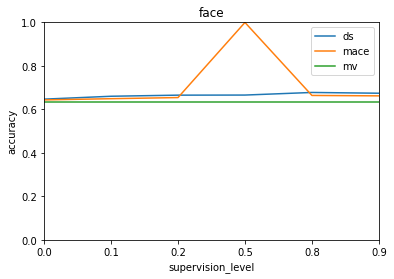

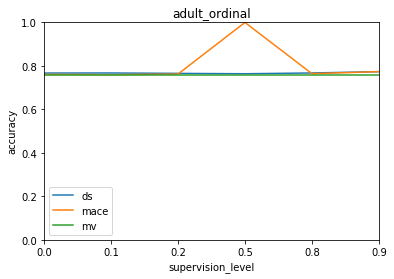

In [6]:
tasks = ['face', 'adult_ordinal']

for task in tasks:
    df_ds = get_ds_supervision(task)
    df_mace = get_mace_supervision(task)

    df = df_ds.join(df_mace, how='inner')
    df['mv'] = get_mv(task)

    df.index = df_ds.index.astype(str)
    ax = df.plot.line(title=task)
    ax.set_ylabel('accuracy')
    ax.set_ylim(0,1)

In [7]:
def get_ds_noise(task):
    df_ds = pd.read_csv('DawidSkene/results/results-noise-supervised/DS/results_noise_supervised_' + task + '.csv')[['level','noise_level', 'accuracy']]
    df_ds.columns = ['supervision_level','noise_level', 'ds']
    df_ds = df_ds.groupby(['noise_level', 'supervision_level']).mean()
    return df_ds

def get_mace_noise(task):
    df_mace = pd.read_csv('MACE/results/results-noise-supervised/results_noise_supervised_' + task + '.csv')[['level','noise_level', 'accuracy']]
    df_mace.columns = ['supervision_level','noise_level', 'mace']
    df_mace = df_mace.groupby(['noise_level', 'supervision_level']).mean()
    return df_mace

In [8]:
# tasks = ['face', 'adult_ordinal', 'waterbird']

# for task in tasks:
#     df_ds = get_ds_noise(task)
#     df_mace = get_mace_noise(task)

#     df = df_ds.join(df_mace, how='inner', lsuffix='_ds', rsuffix='_mace')
# #     df['mv'] = get_mv(task)

#     df.index = df_ds.index.astype(str)
#     ax = df.plot.line(title=task)
#     ax.set_ylabel('accuracy')
#     ax.set_ylim(0,1)

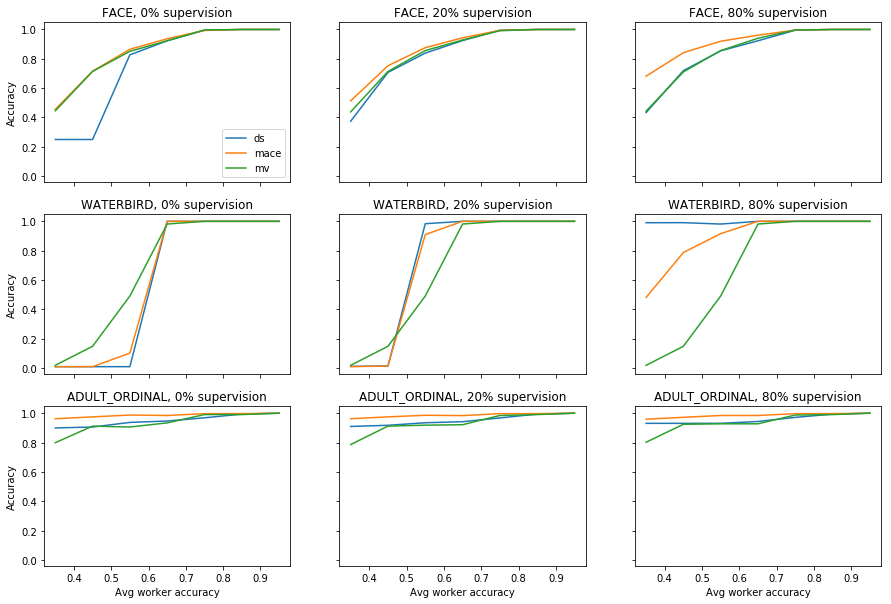

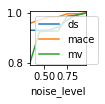

In [9]:
tasks = ['face', 'waterbird', 'adult_ordinal']
# tasks = ['face']
levels = [0.0, 0.2, 0.8]
# levels = [0.0]

fig, axs = plt.subplots(len(tasks), len(levels), sharex=True, sharey=True, figsize=(15,10))

for i in range(len(tasks)):
    task = tasks[i]
    for j in range(len(levels)):
        level = levels[j]
        df_ds = get_ds_noise(task)
        df_mace = get_mace_noise(task)

        df = df_ds.join(df_mace, how='inner', lsuffix='_ds', rsuffix='_mace')
        df['mv'] = df.index.map(lambda x: get_mv_noise(task, x[0]))
        
        df.reset_index(inplace=True) 
        df_at_level = df[df['supervision_level'] == level].set_index('noise_level')[['ds', 'mace','mv']]
#         ax = df_at_level.plot.line(title=(task.upper() + ", " + str(int(level * 100)) + "% supervision"))
#         ax.set_ylabel('accuracy')
#         ax.set_ylim(0,1)
#         h, l = ax.get_legend_handles_labels()
#         print(h,l)
        
#         f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
#         ax1.plot(df_at_level.index, df_at_level[['ds', 'mace', 'mv']])
#         ax2.plot(df_at_level.index, df_at_level[['ds', 'mace', 'mv']])
#         ax3.plot(df_at_level.index, df_at_level[['ds', 'mace', 'mv']])
#         ax1.set_title('Sharing Y axis')

        axs[i,j].plot(df_at_level.index, df_at_level[['ds', 'mace', 'mv']])
        axs[i,j].set_title(task.upper() + ", " + str(int(level * 100)) + "% supervision")

ax = df_at_level.plot(figsize=(1,1))
h, l = ax.get_legend_handles_labels()
axs[0,0].legend(h,l,loc="lower right")


for i in range(len(tasks)):
    axs[i,0].set_ylabel('Accuracy')
    
for i in range(len(levels)):
    axs[len(tasks) - 1,i].set_xlabel('Avg worker accuracy')